In [1316]:
%run cv.ipynb

In [2]:
train = pd.read_csv(input_path + '/train_data.csv', sep=',')
test = pd.read_csv(input_path + '/test_data.csv', sep=',')
train_answers = pd.read_csv(input_path + '/train_answers.csv', sep=',')

In [3]:
len(train.userId.unique()), len(test.userId.unique()), len(np.intersect1d(train.userId.unique(), test.userId.unique()))

(1357, 1192, 1001)

In [4]:
tr = train.join(train_answers.set_index('itemId'), how='left', on='itemId')
tr['isMinmax'] = (tr.Xmin_true <= tr.Xmin) & (tr.Xmax <= tr.Xmax_true) & (tr.Ymin_true <= tr.Ymin) & (tr.Ymax <= tr.Ymax_true)
tr.groupby('itemId').agg({'isMinmax': 'all'}).mean()

isMinmax    0.103924
dtype: float64

In [5]:
tr = train.join(train_answers.set_index('itemId'), how='left', on='itemId')
tr['isMinmax'] = (tr.Xmax_true >= tr.Xmax)
tr.groupby('itemId').agg({'isMinmax': 'all'}).mean()

isMinmax    0.481442
dtype: float64

In [14]:
(train.Ymin <= train.Ymax).mean()

1.0

In [739]:
class MinMaxModel2(MyModel):
    def fit(self, train, train_answers):
        pass
    def get_base_result(self, X):
        sssdd()
        result = []
        for items in split_by(X, 'itemId'):
            x1 = items.Xmin.min()
            x2 = items.Xmax.max()
            y1 = items.Ymin.min()
            y2 = items.Ymax.max()
            itemId = items.itemId.values[0]
            result.append([itemId, x1, y1, x2, y2])
        return result      
    def get_base_result_cached(self, X):
        if self.params.get('use_cache', False):
            self.params['_predict_cache'] = self.params.get('_predict_cache', {})
            h = get_df_hash(X)
            if h in self.params['_predict_cache']:
                minmax_result = self.params['_predict_cache'][h]
            else:
                minmax_result = self.get_base_result(X)
                self.params['_predict_cache'][h] = minmax_result
        else:
            minmax_result = self.get_base_result(X)
            
        return copy.deepcopy(minmax_result)
    def predict(self, X):
        minmax_result = self.get_base_result_cached(X)
        for row in minmax_result:
            if row[1] >= 70:
                row[1] -= row[1] * self.params.get('mult')
            
        return pd.DataFrame(minmax_result, columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']) 
#model = MinMaxModel2()
#model.fit(train, train_answers)
#print(get_score(train_answers, model.predict(train)))

In [671]:
cross_validation(MinMaxModel2({'mult':14/60.0}), train, train_answers)

KFold(n_splits=5, random_state=2707, shuffle=True)
 0 - 1 : 0.5868, mean=0.5868
 0 - 2 : 0.5895, mean=0.5881
 0 - 3 : 0.5714, mean=0.5826
 0 - 4 : 0.5804, mean=0.5820
 0 - 5 : 0.5925, mean=0.5841
KFold(n_splits=5, random_state=2708, shuffle=True)
 1 - 1 : 0.5774, mean=0.5830
 1 - 2 : 0.5873, mean=0.5836
 1 - 3 : 0.5764, mean=0.5827
 1 - 4 : 0.5942, mean=0.5840
 1 - 5 : 0.5851, mean=0.5841
KFold(n_splits=5, random_state=2709, shuffle=True)
 2 - 1 : 0.5869, mean=0.5844
 2 - 2 : 0.5831, mean=0.5843
 2 - 3 : 0.5863, mean=0.5844
 2 - 4 : 0.5819, mean=0.5842
 2 - 5 : 0.5823, mean=0.5841
KFold(n_splits=5, random_state=2710, shuffle=True)
 3 - 1 : 0.5806, mean=0.5839
 3 - 2 : 0.5755, mean=0.5834
 3 - 3 : 0.5805, mean=0.5832
 3 - 4 : 0.6060, mean=0.5844
 3 - 5 : 0.5779, mean=0.5841
KFold(n_splits=5, random_state=2711, shuffle=True)
 4 - 1 : 0.5862, mean=0.5842
 4 - 2 : 0.5833, mean=0.5842
 4 - 3 : 0.5966, mean=0.5847
 4 - 4 : 0.5657, mean=0.5839
 4 - 5 : 0.5886, mean=0.5841


0.5841022446006188

In [1343]:
class GeneticSearchModel(MyModel):
    def __init__(self, params={}):
        self.model_class = MinMaxModelEx2
        self.params = params
        self.sub_params = {
            'use_cache': True,
        }
    def fit(self, train, train_answers):
        self.train = train
        self.train_answers = train_answers
        self.population = Population(size=self.params['size'], items=[
            MutableFloatFactory(min_value=0.2, max_value=1.5),
            MutableFloatFactory(min_value=0.2, max_value=1.5),
            MutableFloatFactory(min_value=50, max_value=150),
            MutableFloatFactory(min_value=8, max_value=25),
            MutableFloatFactory(min_value=8, max_value=25),
            MutableFloatFactory(min_value=0, max_value=1),
            MutableFloatFactory(min_value=0, max_value=1),
            MutableFloatFactory(min_value=5, max_value=45),
            MutableFloatFactory(min_value=5, max_value=45),
        ], score_getter=lambda x: self.score_getter(x))
        for i in range(self.params['epochs']):
            self.population.do_epoch()
        
    def set_sub_params(self, params):
        self.sub_params['mult_dx'],\
        self.sub_params['mult_dd'],\
        self.sub_params['thr1'],\
        self.sub_params['thr2'],\
        self.sub_params['thr3'],\
        self.sub_params['c1'],\
        self.sub_params['c2'],\
        self.sub_params['p1'],\
        self.sub_params['p2']\
        = params
        
#        self.sub_params['mult_x1_sqrt'],\
#        self.sub_params['mult_x1'],\
        
    def score_getter(self, params):
        self.set_sub_params(params)
        model = self.model_class(self.sub_params)
        model.fit(self.train, self.train_answers)
        return get_score(self.train_answers, model.predict(self.train)) 
    
    def predict(self, X):
        params = self.population.get_best_values()
        self.set_sub_params(params)
        model = self.model_class(self.sub_params)
        model.fit(self.train, self.train_answers)
        return model.predict(X)

In [1344]:
# genetic

class LgbModel(MyModel):
    def get_X(self, data):
        return data[self.params['feats']]
    def fit(self, data):
        lgb_train = lgb.Dataset(self.get_X(data), data['target'])
        params = self.params.copy()
        num_boost_round = params['num_boost_round']
        del params['num_boost_round']
        del params['feats']
        params['objective'] = 'fair'
        self.model = lgb.train(params, lgb_train, num_boost_round=num_boost_round)
    def predict(self, data):
        return self.model.predict(self.get_X(data))
            
class MinMaxModelEx2(MinMaxModel2):
    def fit(self, train, train_answers):
        self.x1_targeter = lambda df: ppow(df.Xmin_min - df.Xmin_true, 1.0) # сколько нужно отнять от Xmin
        
        h = get_df_hash(train)
        if self.params.get('use_cache', False):
            self.params['_fit_cache'] = self.params.get('_fit_cache', {})
            if h not in self.params['_fit_cache']:
                feats_x1 = create_df(create_features(train), train_answers, aggr=True, targeter=self.x1_targeter)
                params = {
                    'boosting_type': 'gbdt',
                    'min_data_in_leaf': 100,
                    'lambda_l2': 0.5,
                    'num_leaves': 5,
                    'learning_rate': 0.007,
                    'feature_fraction': 1,
                    'bagging_fraction': 1,
                    'bagging_freq': 1,
                    'num_boost_round': 700,
                    'verbose': 0,
                }
                model_x1 = LgbModel(dict(params, feats=['Xmin_min']))
                model_x1.fit(feats_x1)
                self.params['_fit_cache'][h] = model_x1
            else:
                model_x1 = self.params['_fit_cache'][h]
        else:
            sdsdsdsd()
            
        self.model_x1 = model_x1
    def get_base_result(self, X):
        feats_x1 = create_df(create_features(X), None, aggr=True, targeter=self.x1_targeter)

        pred = pd.DataFrame({
            'itemId': feats_x1.itemId,
            'target_x1': self.model_x1.predict(feats_x1),
        })
        assert pred.shape[0] == feats_x1.shape[0]
        
        result = []
        for items in feats_x1.join(pred.set_index('itemId'), on='itemId').itertuples():
            x1 = items.Xmin_min
            y1 = items.Ymin_min
            x2 = items.Xmax_max
            y2 = items.Ymax_max
            x1_init = x1
            if x1 >= 70:
                x1 -= items.target_x1

            result.append([items.itemId, x1, y1, x2, y2, x1_init, items.Xmax_max2 - items.Xmax_max])
        return result
        
    def predict(self, X):
        minmax_result = self.get_base_result_cached(X)
        result = []
        
        mult_dx = self.params.get('mult_dx')
        mult_dd = self.params.get('mult_dd')
        thr1 = self.params.get('thr1')
        thr2 = self.params.get('thr2')
        thr3 = self.params.get('thr3')
        c1 = self.params.get('c1')
        c2 = self.params.get('c2')
        p1 = self.params.get('p1')
        p2 = self.params.get('p2')
        
        for itemId, x1, y1, x2, y2, x1_orig, x1_delta in minmax_result:
            if x1_orig >= 70:
                x1 -= x2 / 60 * 1.2
            
            dx = (x2 - x1)*mult_dx
            dy = y2 - y1
            if dy > dx:
                dd = (dy - dx)
                y2 -= dd*mult_dd
                if x1 >= thr1:
                    x1 -= dd*c1
                else:
                    x2 += dd*c2
                    
            if y1 < x1*thr3:
                y2 += ((x1*thr3 - y1)/(x1*thr3)) * p1              
                
            if y1 < x1*thr2:
                x1 -= ((x1*thr2 - y1)/(x1*thr2)) * p2
                
            result.append([itemId, x1, y1, x2, y2])
            
        return pd.DataFrame(result, columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']) 

In [1342]:
seed_everything(34322)
cross_validation(GeneticSearchModel({'epochs': 170, 'size': 25}), train, train_answers)

KFold(n_splits=5, random_state=2707, shuffle=True)
Best values: 1.2978861285110646, 1.4430187913091048, 136.4011047287994, 12.348060592554798, 17.955641539619805, 0.46318065574657385, 0.44682741332457654, 37.099030658234994, 7.987467352609476 (score=0.5826285031308863)
Best values: 0.8536324444943535, 0.6408658019848835, 139.34484454644542, 17.363150054317302, 11.38699994593697, 0.42457638292477906, 0.5803168220231354, 9.403603497143218, 39.69942343348722 (score=0.5931910668531761)
Best values: 0.8536324444943535, 0.6408658019848835, 128.89542070159388, 16.16181608633066, 11.86902347550406, 0.8445918322327373, 0.600441650486691, 12.22115897704882, 30.514462968511612 (score=0.5932086049753973)
Best values: 0.8536324444943535, 0.665125033362731, 132.96024341518537, 17.661918492873376, 10.665504666745086, 0.35064039976932726, 0.554293671279763, 21.055851247840767, 20.914622049385493 (score=0.5937285498401234)
Best values: 0.8536324444943535, 0.665125033362731, 132.96024341518537, 17.66191

Best values: 0.7626048492170239, 0.5801407756168633, 90.11085351831761, 16.10224604889576, 12.4628398184495, 0.0, 0.42433830458007027, 21.391913542002037, 22.346800458754288 (score=0.5943430837010155)
Best values: 0.7626048492170239, 0.5801407756168633, 90.11085351831761, 16.10224604889576, 12.4628398184495, 0.0, 0.42433830458007027, 21.391913542002037, 22.346800458754288 (score=0.5943430837010155)
Best values: 0.7626048492170239, 0.5801407756168633, 79.79626396980609, 17.627935824152352, 15.498129007721712, 0.020254259928891304, 0.396323006855747, 16.23212389014122, 21.697403759692886 (score=0.5944503976325415)
Best values: 0.7626048492170239, 0.5801407756168633, 79.79626396980609, 17.627935824152352, 15.498129007721712, 0.020254259928891304, 0.396323006855747, 16.23212389014122, 21.697403759692886 (score=0.5944503976325415)
Best values: 0.7626048492170239, 0.5801407756168633, 79.79626396980609, 17.627935824152352, 15.498129007721712, 0.020254259928891304, 0.396323006855747, 16.232123

Best values: 0.746796060155198, 0.5466291797240683, 75.09223370497978, 16.5594497977837, 15.056556278249406, 0.006329456227778533, 0.4071841509015014, 19.0009184803455, 30.48282502110921 (score=0.5948235030625721)
Best values: 0.7487960822308439, 0.5523943003767651, 75.09223370497978, 16.69817681158117, 14.859990343418456, 0.013977223043371668, 0.41292525312616607, 18.949561419408326, 28.945760688169603 (score=0.5948291435911784)
Best values: 0.7487960822308439, 0.5523943003767651, 75.09223370497978, 16.69817681158117, 14.859990343418456, 0.013977223043371668, 0.41292525312616607, 18.949561419408326, 28.945760688169603 (score=0.5948291435911784)
Best values: 0.7480199732563131, 0.5485818456158666, 75.09223370497978, 16.860160321659677, 14.883152746379295, 0.005341838128201557, 0.4071841509015014, 19.119028638283595, 27.49074125097261 (score=0.5948430625915264)
Best values: 0.7480199732563131, 0.5485818456158666, 75.09223370497978, 16.898031710929118, 14.883152746379295, 0.0058356471779

Best values: 0.7480199732563131, 0.544873040866565, 75.08345828341923, 16.860160321659677, 14.872804480349444, 0.00054994466049756, 0.40660869010757594, 18.16997977109408, 26.944381361371164 (score=0.5948508092798525)
Best values: 0.7480199732563131, 0.544873040866565, 75.08345828341923, 16.860160321659677, 14.872804480349444, 0.00054994466049756, 0.40660869010757594, 18.16997977109408, 26.944381361371164 (score=0.5948508092798525)
Best values: 0.7480199732563131, 0.544873040866565, 75.08784599419951, 16.860160321659677, 14.87797861336437, 0.0, 0.40660869010757594, 18.16997977109408, 26.944381361371164 (score=0.5948513491816823)
Best values: 0.7480199732563131, 0.544873040866565, 75.08784599419951, 16.860160321659677, 14.87797861336437, 0.0, 0.40660869010757594, 18.16997977109408, 26.944381361371164 (score=0.5948513491816823)
Best values: 0.7480199732563131, 0.544873040866565, 75.08784599419951, 16.860160321659677, 14.87797861336437, 0.0, 0.40660869010757594, 18.16997977109408, 26.9443

Best values: 0.7479919854984016, 0.5436812910550439, 75.08318405149546, 16.860160321659677, 14.925057834282038, 0.0, 0.41054895980981165, 18.23959081394178, 26.503044980764 (score=0.5948552473828159)
Best values: 0.7479919854984016, 0.5436812910550439, 75.08318405149546, 16.860160321659677, 14.925057834282038, 0.0, 0.41054895980981165, 18.23959081394178, 26.503044980764 (score=0.5948552473828159)
Best values: 0.7479919854984016, 0.5436812910550439, 75.08318405149546, 16.860160321659677, 14.925057834282038, 0.0, 0.41054895980981165, 18.23959081394178, 26.503044980764 (score=0.5948552473828159)
Best values: 0.7479919854984016, 0.5436812910550439, 75.08318405149546, 16.860160321659677, 14.925057834282038, 0.0, 0.41054895980981165, 18.23959081394178, 26.503044980764 (score=0.5948552473828159)
Best values: 0.7479919854984016, 0.5436812910550439, 75.08318405149546, 16.860160321659677, 14.925057834282038, 0.0, 0.41054895980981165, 18.23959081394178, 26.503044980764 (score=0.5948552473828159)


Best values: 0.7621657876550455, 0.5907130508725893, 80.88180007685122, 17.841129280966484, 15.056665315720501, 0.24057112217291882, 0.4167271671689796, 17.79525396408678, 22.08209978665028 (score=0.5945855780144051)
Best values: 0.7621657876550455, 0.5919288090648179, 81.22349240586948, 17.841129280966484, 13.525689508592489, 0.1940538273543351, 0.38783555379248125, 22.54908307467565, 25.662262767344814 (score=0.5946001564472029)
Best values: 0.7621657876550455, 0.5919288090648179, 81.22349240586948, 17.841129280966484, 13.525689508592489, 0.1940538273543351, 0.38783555379248125, 22.54908307467565, 25.662262767344814 (score=0.5946001564472029)
Best values: 0.7621657876550455, 0.5919288090648179, 81.22349240586948, 17.841129280966484, 13.525689508592489, 0.1940538273543351, 0.38783555379248125, 22.54908307467565, 25.662262767344814 (score=0.5946001564472029)
Best values: 0.7925790821862814, 0.6384134659042005, 81.25619784688013, 17.882101884034984, 16.271576850189476, 0.146719658687012

Best values: 0.7597541561510526, 0.609026445633235, 81.01811106048572, 17.226935075513822, 14.992419533349967, 0.13211053666368539, 0.3960667969031541, 22.695466586505354, 26.062016092643034 (score=0.594770333776904)
Best values: 0.7597541561510526, 0.609026445633235, 81.01811106048572, 17.226935075513822, 14.992419533349967, 0.13211053666368539, 0.3960667969031541, 22.695466586505354, 26.062016092643034 (score=0.594770333776904)
Best values: 0.7600476422000481, 0.6099388774228158, 81.01811106048572, 17.402893756521987, 14.947449472807207, 0.13244076848938097, 0.38161751327982785, 22.695466586505354, 25.998132003565985 (score=0.5947750925181873)
Best values: 0.7600476422000481, 0.6099388774228158, 81.01811106048572, 17.402893756521987, 14.947449472807207, 0.13244076848938097, 0.38161751327982785, 22.695466586505354, 25.998132003565985 (score=0.5947750925181873)
Best values: 0.7600476422000481, 0.6099388774228158, 81.01811106048572, 17.402893756521987, 14.947449472807207, 0.132440768489

Best values: 0.7538518699290595, 0.6089845547267496, 80.97233338426369, 17.272735684947083, 14.939309212812082, 0.1301226413253938, 0.38239075542485296, 22.38518907481229, 25.72379510400941 (score=0.5947833339309008)
Best values: 0.7538518699290595, 0.6089845547267496, 80.97233338426369, 17.272735684947083, 14.939309212812082, 0.1301226413253938, 0.38239075542485296, 22.38518907481229, 25.72379510400941 (score=0.5947833339309008)
Best values: 0.7538518699290595, 0.6089845547267496, 80.97233338426369, 17.272735684947083, 14.939309212812082, 0.1301226413253938, 0.38239075542485296, 22.38518907481229, 25.72379510400941 (score=0.5947833339309008)
Best values: 0.7538518699290595, 0.6089845547267496, 80.97233338426369, 17.272735684947083, 14.939309212812082, 0.1301226413253938, 0.38239075542485296, 22.38518907481229, 25.72379510400941 (score=0.5947833339309008)
Best values: 0.7538518699290595, 0.6089845547267496, 80.97233338426369, 17.272735684947083, 14.939309212812082, 0.1301226413253938, 

Best values: 0.7569314131864916, 0.6089845547267496, 80.97233338426369, 17.8030670299093, 14.904959357699708, 0.11975885751116622, 0.3743928714681647, 22.466712985509936, 25.201726782143588 (score=0.5947940630143042)
Best values: 0.7569314131864916, 0.6089845547267496, 80.97233338426369, 17.8030670299093, 14.904959357699708, 0.11975885751116622, 0.3743928714681647, 22.466712985509936, 25.201726782143588 (score=0.5947940630143042)
Best values: 0.7569314131864916, 0.6089845547267496, 80.97233338426369, 17.8030670299093, 14.904959357699708, 0.11975885751116622, 0.3743928714681647, 22.466712985509936, 25.201726782143588 (score=0.5947940630143042)
Best values: 0.7569284038080595, 0.609262121620812, 80.97233338426369, 17.8030670299093, 14.89202451571863, 0.1287318082116844, 0.3743928714681647, 22.422966736375965, 24.819161268217986 (score=0.5947946225843571)
Best values: 0.7569284038080595, 0.609262121620812, 80.97233338426369, 17.8030670299093, 14.89202451571863, 0.1287318082116844, 0.37439

Best values: 0.8357135991488116, 0.6756760674270468, 108.61227707299182, 17.116162228749722, 11.271433888821196, 0.18752532812061365, 0.49336061492135747, 18.008916488109435, 28.656124771213502 (score=0.5984517697366758)
Best values: 0.766039033861484, 0.5320951647727783, 73.85598355783412, 17.12153611061687, 14.948966200502824, 0.22122022668145297, 0.3139168027925501, 20.539951718920406, 30.509377915178195 (score=0.5991116803332664)
Best values: 0.766039033861484, 0.5320951647727783, 73.85598355783412, 17.12153611061687, 14.948966200502824, 0.22122022668145297, 0.3139168027925501, 20.539951718920406, 30.509377915178195 (score=0.5991116803332664)
Best values: 0.766039033861484, 0.5320951647727783, 73.85598355783412, 17.12153611061687, 14.948966200502824, 0.22122022668145297, 0.3139168027925501, 20.539951718920406, 30.509377915178195 (score=0.5991116803332664)
Best values: 0.7676116876102342, 0.6481979602720969, 83.48313509100964, 17.341745610240256, 13.0499790720033, 0.2357566045242685

Best values: 0.7375569661686028, 0.5480904805643172, 81.13845942478655, 17.74722255444778, 14.87185712772926, 0.09470014650430764, 0.32924180242186635, 19.710035522242748, 25.272497427286396 (score=0.5998788368624666)
Best values: 0.7375569661686028, 0.5480904805643172, 81.13845942478655, 17.74722255444778, 14.87185712772926, 0.09470014650430764, 0.32924180242186635, 19.710035522242748, 25.272497427286396 (score=0.5998788368624666)
Best values: 0.7375569661686028, 0.5480904805643172, 81.13845942478655, 17.74722255444778, 14.87185712772926, 0.09470014650430764, 0.32924180242186635, 19.710035522242748, 25.272497427286396 (score=0.5998788368624666)
Best values: 0.7375569661686028, 0.5480904805643172, 81.13845942478655, 17.74722255444778, 14.87185712772926, 0.09470014650430764, 0.32924180242186635, 19.710035522242748, 25.272497427286396 (score=0.5998788368624666)
Best values: 0.7375569661686028, 0.5480904805643172, 81.13845942478655, 17.74722255444778, 14.87185712772926, 0.0947001465043076

Best values: 0.7384693341828148, 0.5513776986089218, 78.6586331980302, 17.90608339131387, 15.07067663710703, 0.07975430192605903, 0.33581649159048915, 18.176693416715445, 25.148645202307215 (score=0.5999125205839073)
Best values: 0.7384693341828148, 0.5513776986089218, 78.6586331980302, 17.90608339131387, 15.07067663710703, 0.07975430192605903, 0.33581649159048915, 18.176693416715445, 25.148645202307215 (score=0.5999125205839073)
Best values: 0.7384693341828148, 0.5513776986089218, 78.6586331980302, 17.90608339131387, 15.07067663710703, 0.07975430192605903, 0.33581649159048915, 18.176693416715445, 25.148645202307215 (score=0.5999125205839073)
Best values: 0.7368619475144769, 0.5513776986089218, 78.50325337552525, 17.90608339131387, 15.08461049826034, 0.07975430192605903, 0.33581649159048915, 18.60998613629212, 25.213631225473026 (score=0.5999166326407869)
Best values: 0.7368619475144769, 0.5513776986089218, 78.50325337552525, 17.90608339131387, 15.08461049826034, 0.07975430192605903, 0

Best values: 0.7354214540632369, 0.5495792144955869, 78.73873496277814, 17.936636643962565, 15.104081262420536, 0.07975430192605903, 0.33040496464701785, 17.930205718811116, 25.210223347575187 (score=0.5999236571559491)
Best values: 0.7354214540632369, 0.5495792144955869, 78.73873496277814, 17.936636643962565, 15.104081262420536, 0.07975430192605903, 0.33040496464701785, 17.930205718811116, 25.210223347575187 (score=0.5999236571559491)
Best values: 0.7354214540632369, 0.5495792144955869, 78.73873496277814, 17.936636643962565, 15.104081262420536, 0.07975430192605903, 0.33040496464701785, 17.930205718811116, 25.210223347575187 (score=0.5999236571559491)
Best values: 0.7354214540632369, 0.5495792144955869, 78.73873496277814, 17.936636643962565, 15.104081262420536, 0.07975430192605903, 0.33040496464701785, 17.930205718811116, 25.210223347575187 (score=0.5999236571559491)
Best values: 0.7354214540632369, 0.5495792144955869, 78.73873496277814, 17.936636643962565, 15.104081262420536, 0.079754

Best values: 0.7362810213311657, 0.5463808831039266, 78.45146010135694, 17.990891270449453, 15.104081262420536, 0.0804222595122919, 0.33212234292947207, 17.77969474197986, 24.006193547159548 (score=0.5999282279711579)
Best values: 0.7362810213311657, 0.5463808831039266, 78.45146010135694, 17.990891270449453, 15.104081262420536, 0.0804222595122919, 0.33212234292947207, 17.77969474197986, 24.006193547159548 (score=0.5999282279711579)
Best values: 0.736428339428816, 0.5477688415023998, 78.60108242501383, 17.999069207127356, 15.104081262420536, 0.0804222595122919, 0.33380696441498486, 17.850635159447314, 24.500309770317422 (score=0.5999295231412715)
Best values: 0.736428339428816, 0.5477688415023998, 78.60108242501383, 17.999069207127356, 15.104081262420536, 0.0804222595122919, 0.33380696441498486, 17.850635159447314, 24.500309770317422 (score=0.5999295231412715)
Best values: 0.736428339428816, 0.5477688415023998, 78.60108242501383, 17.999069207127356, 15.104081262420536, 0.080422259512291

Best values: 0.7516974720042007, 0.6238746039850354, 81.27335950524512, 11.950997994003812, 16.56574193831799, 0.1070419244122164, 0.31330962146002994, 22.301890910490496, 39.00395872910308 (score=0.5961361425826978)
Best values: 0.7516974720042007, 0.6238746039850354, 81.27335950524512, 11.950997994003812, 16.56574193831799, 0.1070419244122164, 0.31330962146002994, 22.301890910490496, 39.00395872910308 (score=0.5961361425826978)
Best values: 0.7559451604021866, 0.6042025866246608, 80.41416879973585, 12.69659418491438, 14.734447452090539, 0.1070419244122164, 0.3027765320008938, 23.532555993077303, 37.410604032645836 (score=0.5961395174297692)
Best values: 0.7559451604021866, 0.6042025866246608, 80.41416879973585, 12.69659418491438, 14.734447452090539, 0.1070419244122164, 0.3027765320008938, 23.532555993077303, 37.410604032645836 (score=0.5961395174297692)
Best values: 0.7559451604021866, 0.6042025866246608, 80.41416879973585, 12.69659418491438, 14.734447452090539, 0.1070419244122164, 0

Best values: 0.7533083285123474, 0.6097975953469152, 80.86683581727054, 12.103997586099988, 15.046127703626428, 0.1070419244122164, 0.3026253473478521, 22.542576016206514, 39.39593109764242 (score=0.5961813849006187)
Best values: 0.7533083285123474, 0.6097975953469152, 80.86683581727054, 12.103997586099988, 15.046127703626428, 0.1070419244122164, 0.3026253473478521, 22.542576016206514, 39.39593109764242 (score=0.5961813849006187)
Best values: 0.7533083285123474, 0.6097975953469152, 80.86683581727054, 12.103997586099988, 15.046127703626428, 0.1070419244122164, 0.3026253473478521, 22.542576016206514, 39.39593109764242 (score=0.5961813849006187)
Best values: 0.7533083285123474, 0.6097975953469152, 80.86683581727054, 12.103997586099988, 15.046127703626428, 0.1070419244122164, 0.3026253473478521, 22.542576016206514, 39.39593109764242 (score=0.5961813849006187)
Best values: 0.7533083285123474, 0.6097975953469152, 80.86683581727054, 12.103997586099988, 15.046127703626428, 0.1070419244122164, 

Best values: 0.7534034091552516, 0.6083401483390446, 80.93052081200372, 12.033497018253808, 15.030392411802854, 0.1070419244122164, 0.3013591242614586, 23.363399574180548, 41.07590040178831 (score=0.5961909292752698)
Best values: 0.7534034091552516, 0.6083401483390446, 80.93052081200372, 12.033497018253808, 15.030392411802854, 0.1070419244122164, 0.3013591242614586, 23.363399574180548, 41.07590040178831 (score=0.5961909292752698)
Best values: 0.7534034091552516, 0.6083401483390446, 80.93052081200372, 12.033497018253808, 15.030392411802854, 0.1070419244122164, 0.3013591242614586, 23.363399574180548, 41.07590040178831 (score=0.5961909292752698)
Best values: 0.7533494650970063, 0.6083401483390446, 80.93052081200372, 12.033497018253808, 15.016719150313444, 0.1070419244122164, 0.3013591242614586, 23.363399574180548, 41.07590040178831 (score=0.5961914554972928)
Best values: 0.7533494650970063, 0.6083401483390446, 80.93052081200372, 12.033497018253808, 15.016719150313444, 0.1070419244122164, 

Best values: 0.7531628080366835, 0.6073204316172753, 80.90110600689543, 12.040547075038425, 14.847235966318681, 0.1070419244122164, 0.3014087939241156, 23.175288652701617, 40.8770410988957 (score=0.5961964973032639)
Best values: 0.7531628080366835, 0.6073204316172753, 80.90110600689543, 12.040547075038425, 14.847235966318681, 0.1070419244122164, 0.3014087939241156, 23.175288652701617, 40.8770410988957 (score=0.5961964973032639)
Best values: 0.7531628080366835, 0.6073204316172753, 80.90110600689543, 12.040547075038425, 14.847235966318681, 0.1070419244122164, 0.3014087939241156, 23.175288652701617, 40.8770410988957 (score=0.5961964973032639)
Best values: 0.7531628080366835, 0.6073204316172753, 80.90110600689543, 12.040547075038425, 14.847235966318681, 0.1070419244122164, 0.3014087939241156, 23.175288652701617, 40.8770410988957 (score=0.5961964973032639)
Best values: 0.7531628080366835, 0.6073204316172753, 80.90110600689543, 12.040547075038425, 14.847235966318681, 0.1070419244122164, 0.30

Best values: 0.8009182627172198, 0.7232093274156142, 89.0791328990972, 13.404887037793866, 13.707737120976187, 0.2663338059787202, 0.5093856709784411, 29.9725873136028, 24.340134473454615 (score=0.5923583655376348)
Best values: 0.8009182627172198, 0.7232093274156142, 89.0791328990972, 13.404887037793866, 13.707737120976187, 0.2663338059787202, 0.5093856709784411, 29.9725873136028, 24.340134473454615 (score=0.5923583655376348)
Best values: 0.7968865630067714, 0.7232093274156142, 98.61767055460689, 16.6095504185296, 12.30770292039827, 0.26044694406982277, 0.5481469562354808, 17.57217388132437, 25.435997249016516 (score=0.5924779194797783)
Best values: 0.8024423320451868, 0.7211739278429787, 88.40321130054795, 15.294247719882975, 12.518006331194524, 0.23018366105787075, 0.5018709292374146, 22.530428139929707, 26.636140888222794 (score=0.5927110636196471)
Best values: 0.8024423320451868, 0.7211739278429787, 88.40321130054795, 15.294247719882975, 12.518006331194524, 0.23018366105787075, 0.5

Best values: 0.7894550719900439, 0.7415661971054642, 81.43196110224943, 17.41981751525426, 14.630604322237023, 0.14271576835026567, 0.4921710633876655, 23.684315691162567, 26.95945790034216 (score=0.5935486746005729)
Best values: 0.7894550719900439, 0.7415661971054642, 81.43196110224943, 17.41981751525426, 14.630604322237023, 0.14271576835026567, 0.4921710633876655, 23.684315691162567, 26.95945790034216 (score=0.5935486746005729)
Best values: 0.7912337343932756, 0.7463288529968843, 81.30256459373288, 17.325878425324564, 14.780863768370448, 0.14271576835026567, 0.48831406102771974, 23.03536618725627, 26.60513682814733 (score=0.5935565478622384)
Best values: 0.7912337343932756, 0.7463288529968843, 81.30256459373288, 17.325878425324564, 14.780863768370448, 0.14271576835026567, 0.48831406102771974, 23.03536618725627, 26.60513682814733 (score=0.5935565478622384)
Best values: 0.7912337343932756, 0.7463288529968843, 81.30256459373288, 17.325878425324564, 14.780863768370448, 0.1427157683502656

Best values: 0.7894550719900439, 0.7417950135256444, 82.07842561100975, 17.7903827004918, 14.824104428870811, 0.14282887863652124, 0.47080806975124606, 23.895087057586498, 25.642135714272055 (score=0.5935771569006751)
Best values: 0.7894550719900439, 0.7417950135256444, 82.07842561100975, 17.7903827004918, 14.824104428870811, 0.14282887863652124, 0.47080806975124606, 23.895087057586498, 25.642135714272055 (score=0.5935771569006751)
Best values: 0.7894550719900439, 0.7417950135256444, 82.07842561100975, 17.7903827004918, 14.824104428870811, 0.14282887863652124, 0.47080806975124606, 23.895087057586498, 25.642135714272055 (score=0.5935771569006751)
Best values: 0.7894550719900439, 0.7417950135256444, 82.07842561100975, 17.7903827004918, 14.824104428870811, 0.14282887863652124, 0.47080806975124606, 23.895087057586498, 25.642135714272055 (score=0.5935771569006751)
Best values: 0.7894550719900439, 0.7417950135256444, 82.07842561100975, 17.7903827004918, 14.824104428870811, 0.1428288786365212

Best values: 0.7900398179315912, 0.7428712692884093, 82.25223533185078, 18.013301637913763, 14.819993232362734, 0.14745560188883128, 0.47080806975124606, 23.831667969707723, 24.20302692398623 (score=0.5935805986833055)
Best values: 0.7900398179315912, 0.7428712692884093, 82.25223533185078, 18.013301637913763, 14.819993232362734, 0.14745560188883128, 0.47080806975124606, 23.831667969707723, 24.20302692398623 (score=0.5935805986833055)
Best values: 0.7900398179315912, 0.7428712692884093, 82.25223533185078, 18.013301637913763, 14.819993232362734, 0.14745560188883128, 0.47080806975124606, 23.831667969707723, 24.20302692398623 (score=0.5935805986833055)
Best values: 0.7900398179315912, 0.7428712692884093, 82.25223533185078, 18.013301637913763, 14.819993232362734, 0.14745560188883128, 0.47080806975124606, 23.831667969707723, 24.20302692398623 (score=0.5935805986833055)
Best values: 0.7900398179315912, 0.7428712692884093, 82.25223533185078, 18.013301637913763, 14.819993232362734, 0.1474556018

Best values: 0.7740326850153516, 0.7133417532669201, 82.25223533185078, 18.089015293792293, 14.824367084293275, 0.13199780069664163, 0.44771175059771395, 26.273432332325473, 24.846667996035215 (score=0.5935894238761575)
Best values: 0.7740326850153516, 0.7133417532669201, 82.25223533185078, 18.089015293792293, 14.824367084293275, 0.13199780069664163, 0.44771175059771395, 26.273432332325473, 24.846667996035215 (score=0.5935894238761575)
Best values: 0.7740326850153516, 0.7133417532669201, 82.25223533185078, 18.089015293792293, 14.824367084293275, 0.13199780069664163, 0.44771175059771395, 26.273432332325473, 24.846667996035215 (score=0.5935894238761575)
Best values: 0.7740326850153516, 0.7133417532669201, 82.25223533185078, 18.089015293792293, 14.824367084293275, 0.13199780069664163, 0.44771175059771395, 26.273432332325473, 24.846667996035215 (score=0.5935894238761575)
Best values: 0.7740326850153516, 0.7133417532669201, 82.25223533185078, 18.089015293792293, 14.824367084293275, 0.131997

Best values: 0.743730727863037, 0.585041627151234, 80.67438696784863, 16.47779365155814, 16.975828034537102, 0.3379804169543289, 0.35852533508479567, 17.664954639471553, 28.589561389297337 (score=0.5988030628710594)
Best values: 0.7513451825967534, 0.5606925776482858, 80.67438696784863, 17.111079812485478, 16.591728753560705, 0.3099090064477458, 0.3139945993875571, 16.367930200515517, 28.210951002795067 (score=0.5989444935847308)
Best values: 0.7513451825967534, 0.5606925776482858, 80.67438696784863, 17.111079812485478, 16.591728753560705, 0.3099090064477458, 0.3139945993875571, 16.367930200515517, 28.210951002795067 (score=0.5989444935847308)
Best values: 0.7513451825967534, 0.5606925776482858, 80.67438696784863, 17.111079812485478, 16.591728753560705, 0.3099090064477458, 0.3139945993875571, 16.367930200515517, 28.210951002795067 (score=0.5989444935847308)
Best values: 0.7513451825967534, 0.5606925776482858, 80.67438696784863, 17.111079812485478, 16.591728753560705, 0.3099090064477458

Best values: 0.7526656456624649, 0.5679689421916647, 81.05128592067322, 17.086178058823393, 16.517893726242857, 0.28645546297954894, 0.3692857591820365, 16.551532265468847, 27.264238769827358 (score=0.5990214420060108)
Best values: 0.7526656456624649, 0.5679689421916647, 81.05128592067322, 17.086178058823393, 16.517893726242857, 0.28645546297954894, 0.3692857591820365, 16.551532265468847, 27.264238769827358 (score=0.5990214420060108)
Best values: 0.7526656456624649, 0.5689216626236073, 81.05128592067322, 17.026692159562508, 16.526469170832588, 0.25862015598348986, 0.3692857591820365, 16.684237330045477, 26.205851800007906 (score=0.5990214930540708)
Best values: 0.7526656456624649, 0.5689216626236073, 81.05128592067322, 17.026692159562508, 16.526469170832588, 0.25862015598348986, 0.3692857591820365, 16.684237330045477, 26.205851800007906 (score=0.5990214930540708)
Best values: 0.7525580055385099, 0.5642789966269152, 81.05128592067322, 17.03822020809544, 16.454521640125, 0.28645546297954

Best values: 0.7525194182155202, 0.5703489455474722, 80.95858906639307, 17.062660547608473, 16.521109517964007, 0.2888827871263327, 0.36982143711809967, 16.944278766828837, 26.082774269424597 (score=0.5990388723552358)
Best values: 0.7525194182155202, 0.5703489455474722, 80.95858906639307, 17.062660547608473, 16.521109517964007, 0.2888827871263327, 0.36982143711809967, 16.944278766828837, 26.082774269424597 (score=0.5990388723552358)
Best values: 0.7526149178222483, 0.5695669022792184, 80.99392334322039, 17.09286491138797, 16.486207683183927, 0.29009644919972455, 0.3701902087029292, 16.91515572064523, 25.819444798397594 (score=0.5990395150753287)
Best values: 0.7526149178222483, 0.5695669022792184, 80.99392334322039, 17.09286491138797, 16.486207683183927, 0.29009644919972455, 0.3701902087029292, 16.91515572064523, 25.819444798397594 (score=0.5990395150753287)
Best values: 0.7526149178222483, 0.5695669022792184, 80.99392334322039, 17.09286491138797, 16.486207683183927, 0.290096449199724

Best values: 0.7522468738314387, 0.5695669022792184, 80.99782279374307, 17.09286491138797, 16.486207683183927, 0.2894530712692124, 0.3701902087029292, 17.193272669865785, 25.819444798397594 (score=0.599042468163495)
Best values: 0.7522468738314387, 0.5695669022792184, 80.99782279374307, 17.09286491138797, 16.486207683183927, 0.2894530712692124, 0.3701902087029292, 17.193272669865785, 25.819444798397594 (score=0.599042468163495)
Best values: 0.7522468738314387, 0.5695669022792184, 80.99782279374307, 17.09286491138797, 16.486207683183927, 0.2894530712692124, 0.3701902087029292, 17.193272669865785, 25.819444798397594 (score=0.599042468163495)
Best values: 0.7522468738314387, 0.5695669022792184, 80.99782279374307, 17.09286491138797, 16.486207683183927, 0.2894530712692124, 0.3701902087029292, 17.193272669865785, 25.819444798397594 (score=0.599042468163495)
Best values: 0.7522468738314387, 0.5695669022792184, 80.99782279374307, 17.09286491138797, 16.486207683183927, 0.2894530712692124, 0.370

Best values: 0.7682279604594855, 0.5219968928401884, 76.01254378178491, 17.714847670623854, 9.651738716477093, 0.2833464580016807, 0.4397126917594435, 35.262833148441025, 24.92625093434037 (score=0.5997614361195869)
Best values: 0.7682279604594855, 0.5219968928401884, 76.01254378178491, 17.714847670623854, 9.651738716477093, 0.2833464580016807, 0.4397126917594435, 35.262833148441025, 24.92625093434037 (score=0.5997614361195869)
Best values: 0.7682279604594855, 0.5219968928401884, 76.01254378178491, 17.714847670623854, 9.651738716477093, 0.2833464580016807, 0.4397126917594435, 35.262833148441025, 24.92625093434037 (score=0.5997614361195869)
Best values: 0.8078676714022145, 0.6017954886870275, 76.01254378178491, 16.55418312678278, 10.93877198755954, 0.21748422752938212, 0.4397126917594435, 18.726989942510265, 33.006684908020304 (score=0.6000402485063672)
Best values: 0.8078676714022145, 0.6017954886870275, 76.01254378178491, 16.55418312678278, 10.93877198755954, 0.21748422752938212, 0.43

Best values: 0.7496633128588522, 0.5519231048406468, 76.9542197676843, 17.05683722980781, 12.280337339427694, 0.08851631622437672, 0.3721777842821377, 25.234032949446608, 38.85030495794734 (score=0.6007637869626895)
Best values: 0.7496633128588522, 0.5519231048406468, 76.9542197676843, 17.05683722980781, 12.280337339427694, 0.08851631622437672, 0.3721777842821377, 25.234032949446608, 38.85030495794734 (score=0.6007637869626895)
Best values: 0.7511238869627144, 0.5542781089311046, 76.84415089917461, 17.814542039712045, 11.770306912002727, 0.08445930229095025, 0.38621474814750745, 25.464208811355988, 34.41752850666343 (score=0.6007702243505448)
Best values: 0.7511238869627144, 0.5542781089311046, 76.84415089917461, 17.814542039712045, 11.770306912002727, 0.08445930229095025, 0.38621474814750745, 25.464208811355988, 34.41752850666343 (score=0.6007702243505448)
Best values: 0.7503072353496234, 0.545662056960456, 76.50091590090597, 17.325296628738315, 11.574043971331916, 0.08486519743116892

Best values: 0.7489560451561293, 0.5410557417931353, 76.798075828713, 17.37283767507499, 11.56413053917855, 0.0861576722814918, 0.3836828469153615, 27.219522649836303, 38.996729325539185 (score=0.6008050829484008)
Best values: 0.7489560451561293, 0.5410557417931353, 76.798075828713, 17.37283767507499, 11.56413053917855, 0.0861576722814918, 0.3836828469153615, 27.219522649836303, 38.996729325539185 (score=0.6008050829484008)
Best values: 0.7489560451561293, 0.5410557417931353, 76.798075828713, 17.37283767507499, 11.56413053917855, 0.0861576722814918, 0.3836828469153615, 27.219522649836303, 38.996729325539185 (score=0.6008050829484008)
Best values: 0.7489560451561293, 0.5410557417931353, 76.798075828713, 17.37283767507499, 11.56413053917855, 0.0861576722814918, 0.3836828469153615, 27.219522649836303, 38.996729325539185 (score=0.6008050829484008)
Best values: 0.7489560451561293, 0.5410557417931353, 76.798075828713, 17.37283767507499, 11.56413053917855, 0.0861576722814918, 0.38368284691536

Best values: 0.7489560451561293, 0.5410557417931353, 76.71253562006535, 17.31781894020137, 11.540194471636713, 0.06458841579334407, 0.37921636056747665, 28.882133850182747, 39.02045965581634 (score=0.6008228225312742)
Best values: 0.7489560451561293, 0.5410557417931353, 76.71253562006535, 17.31781894020137, 11.540194471636713, 0.06458841579334407, 0.37921636056747665, 28.882133850182747, 39.02045965581634 (score=0.6008228225312742)
Best values: 0.7489560451561293, 0.5410557417931353, 76.71253562006535, 17.31781894020137, 11.540194471636713, 0.06458841579334407, 0.37921636056747665, 28.882133850182747, 39.02045965581634 (score=0.6008228225312742)
Best values: 0.7489560451561293, 0.5410557417931353, 76.8211133639438, 17.247558654280716, 11.540194471636713, 0.055581700257914354, 0.3664744380304609, 28.882133850182747, 38.88503208969885 (score=0.6008231756601017)
Best values: 0.7489560451561293, 0.5410557417931353, 76.8211133639438, 17.247558654280716, 11.540194471636713, 0.055581700257914

KeyboardInterrupt: 

In [1323]:
def create_features(df):
    res = df.copy()
    res['width'] = df.Xmax - df.Xmin
    res['height'] = df.Ymax - df.Ymin
    res['ratio'] = ((res.width - res.height) / (res.width + res.height)).fillna(1)
    
    to_join = []
    to_join.append(df.groupby('itemId').agg({'userId': 'count'}).rename(columns={'userId': 'usersCount'}))
    for j in to_join:
        res = res.join(j, how='left', on='itemId')
    return res
def create_df(feats, answers, aggr=True, targeter=None):
    if targeter is None:
        targeter = lambda res: res.Xmin_min - res.Xmin_true # сколько нужно отнять от Xmin
    
    item_stat = feats.groupby('itemId').agg({'Xmin': 'min'})
    item_stat.rename(columns={'Xmin': 'Xmin_item'}, inplace=True)
    
    res = feats.groupby('itemId' if aggr else ['itemId', 'userId']).apply(lambda a: pd.Series({
        'width': a.width.mean(),
        'height': a.height.mean(),
        'usersCount': a.usersCount.mean(),
        'X_range': a.Xmax.max() - a.Xmin.min(),
        'Xmin_min': a.Xmin.min(),
        'Xmin_min2': min2(a.Xmin),
        'Xmin_max': a.Xmin.max(),
        'Xmin_range': a.Xmin.max() - a.Xmin.min(),
        'Xmin_mean': a.Xmin.mean(),
        'Ymin_min': a.Ymin.min(),
        'Xmax_max': a.Xmax.max(),
        'Xmax_max2': max2(a.Xmax),
        'Ymax_max': a.Ymax.max(),
        'ratio_min': a.ratio.min(),
        'ratio_max': a.ratio.max(),
        'ratio_mean': a.ratio.mean(),
    }))
    res.reset_index(inplace=True)
    res = res.join(item_stat, on='itemId')
    
    if answers is not None:
        res = res.merge(answers, on='itemId')
        res['target'] = targeter(res)
        res.drop(['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true'], 1, inplace=True)
    return res

create_df(create_features(train), train_answers, aggr=True).head(20)

,itemId,width,height,usersCount,X_range,Xmin_min,Xmin_min2,Xmin_max,Xmin_range,Xmin_mean,Ymin_min,Xmax_max,Xmax_max2,Ymax_max,ratio_min,ratio_max,ratio_mean,Xmin_item,target
0,5,317.000000,330.000000,3.0,360.0,151.0,192.0,210.0,59.0,184.333333,914.0,511.0,510.0,1331.0,-0.134694,0.194030,-0.011730,151,-47.0
1,10,328.666667,292.666667,3.0,355.0,72.0,95.0,96.0,24.0,87.666667,559.0,427.0,420.0,858.0,0.014925,0.094340,0.057222,72,46.0
2,13,527.000000,363.666667,3.0,575.0,46.0,69.0,94.0,48.0,69.666667,600.0,621.0,608.0,981.0,0.134948,0.218220,0.182376,46,-187.0
3,30,177.800000,93.600000,5.0,259.0,65.0,85.0,124.0,59.0,91.400000,353.0,324.0,323.0,491.0,-0.333333,0.434903,0.180328,65,4.0
4,32,228.000000,200.833333,6.0,379.0,9.0,17.0,42.0,33.0,28.166667,279.0,388.0,387.0,884.0,0.023810,0.087770,0.062097,9,-21.0
5,48,102.666667,70.666667,3.0,113.0,50.0,52.0,55.0,5.0,52.333333,1029.0,163.0,158.0,1103.0,0.170455,0.208556,0.183662,50,-35.0
6,64,191.333333,135.666667,3.0,222.0,22.0,26.0,30.0,8.0,26.000000,417.0,244.0,235.0,564.0,0.055351,0.218659,0.161273,22,1.0
7,78,506.500000,488.000000,4.0,568.0,49.0,75.0,120.0,71.0,85.750000,194.0,617.0,590.0,707.0,-0.050104,0.107212,0.017273,49,45.0
8,90,348.666667,288.666667,3.0,439.0,35.0,66.0,134.0,99.0,78.333333,269.0,474.0,428.0,608.0,0.046263,0.138781,0.088740,35,-68.0
9,118,93.000000,64.000000,3.0,141.0,47.0,48.0,168.0,121.0,87.666667,1269.0,188.0,186.0,1372.0,-1.000000,0.221239,-0.207674,47,1.0


In [1583]:
class LgbModel(MyModel):
    def get_X(self, data):
        return data[self.params['feats']]
    def fit(self, data):
        lgb_train = lgb.Dataset(self.get_X(data), data['target'])
        params = self.params.copy()
        num_boost_round = params['num_boost_round']
        del params['num_boost_round']
        del params['feats']
        params['objective'] = 'fair'
        self.model = lgb.train(params, lgb_train, num_boost_round=num_boost_round)
    def predict(self, data):
        proba = self.model.predict(self.get_X(data))
        return proba
    
class KerasModel(MyModel):
    def get_X(self, data):
        return data[self.params['feats']].copy()
    def fit(self, data):
        params = self.params
        self.scaler = MyScaler()
        data = data.copy()
        self.scaler.fit_transform(data, inplace=True)
        X = self.get_X(data)
        y = data['target'].values
        
        model = keras.models.Sequential()
        self.model = model

        model.add(keras.layers.Dense(params['n1'], activation = "relu", input_shape=(X.shape[1], )))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.LeakyReLU())

        model.add(keras.layers.Dropout(params['dropout'], noise_shape=None, seed=1))
        model.add(keras.layers.Dense(params['n2'], activation = "relu"))
        model.add(keras.layers.BatchNormalization())
        
        if 'n3' in params:
            model.add(keras.layers.Dropout(params['dropout'], noise_shape=None, seed=1))
            model.add(keras.layers.Dense(params['n3'], activation = "relu"))
            model.add(keras.layers.BatchNormalization())

        model.add(keras.layers.Dense(1, activation = "sigmoid"))
        
        if params['verbose'] > 0:
            model.summary()
        model.compile(
            optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
            loss = "mse",
            metrics = ["mse"]
        )
        results = model.fit(
            X, y,
            epochs=params['epochs'],
            batch_size=params.get('batch_size', 1024),
            verbose=params['verbose']
        )

    def predict(self, X):
        X = self.get_X(X)
        self.scaler.transform(X, inplace=True)
        res = pd.DataFrame({'target': self.model.predict(X)[:,0]})
        self.scaler.invert_transform(res, inplace=True)
        return res.target.values
            
        
class MinMaxModelEx(MyModel):
    def fit(self, train, train_answers):
        self.x1_targeter = lambda df: ppow(df.Xmin_min - df.Xmin_true, 1.0) # сколько нужно отнять от Xmin
        self.x2_targeter = lambda df: df.Xmax_max - df.Xmax_true
#         self.x1_del_targeter = lambda df:(
#                     (df.Xmax_max > df.Xmax_true) & ((df.Xmax_max2 > df.Xmax_true) |
#                                                     (df.Xmax_max - df.Xmax_true > df.Xmax_true - df.Xmax_max2))
#                                          ).astype(np.int8)
        self.x1_del_targeter = lambda df:(
                    (df.Xmin_min < df.Xmin_true) & ((df.Xmin_min2 < df.Xmin_true) |
                                                    (df.Xmin_true - df.Xmin_min > df.Xmin_min2 - df.Xmin_true))
                                         ).astype(np.int8)
        feats_x1 = create_df(create_features(train), train_answers, aggr=True, targeter=self.x1_targeter)
        #feats_x2 = create_df(create_features(train), train_answers, aggr=True, targeter=self.x2_targeter)
        #feats_x1_del = create_df(create_features(train), train_answers, aggr=True, targeter=self.x1_del_targeter)
        params = {
            'boosting_type': 'gbdt',
            'min_data_in_leaf': 100,
            'lambda_l2': 0.5,
            'num_leaves': 5,
            'learning_rate': 0.007,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 1,
            'num_boost_round': 700,
            'verbose': 0,
        }
#         params = {
#             'epochs': 30,
#             'verbose': 0,
#             'n1': 7,
#             'n2': 7,
#             'dropout': 0.1,
#         }
        self.model_x1 = LgbModel(dict(params, feats=['Xmin_min']))
        #self.model_x1 = KerasModel(dict(params, feats=['Xmin_min', 'Ymin_min', 'Xmax_max', 'Ymax_max', 'usersCount',
        #                                              'ratio_mean']))
        self.model_x1.fit(feats_x1)
        #self.model_x2 = LgbModel(dict(params, feats=['Xmin_min', 'Xmax_max', 'Xmax_max2']))
        #self.model_x2.fit(feats_x2)
        #self.model_x1_del = LgbModel(dict(params, feats=['Xmin_min', 'Xmin_min2', 'width', 'usersCount',
        #                                                'Ymin_min', 'ratio_mean'],
        #                                 num_leaves=8))
        #self.model_x1_del.fit(feats_x1_del)
    def predict(self, X):
        feats_x1 = create_df(create_features(X), None, aggr=True, targeter=self.x1_targeter)
        #feats_x2 = create_df(create_features(X), None, aggr=True, targeter=self.x2_targeter)
        #feats_x1_del = create_df(create_features(X), None, aggr=False, targeter=self.x1_del_targeter)
#        assert all(feats_x1.itemId == feats_x2.itemId)
        pred = pd.DataFrame({
            'itemId': feats_x1.itemId,
            'target_x1': self.model_x1.predict(feats_x1),
            #'target_x2': self.model_x2.predict(feats_x2),
        })
        assert pred.shape[0] == feats_x1.shape[0]  
#         pred_no_aggr = pd.DataFrame({
#             'itemId': feats_x1_del.itemId,
#             'userId': feats_x1_del.userId,
#             'target_x1_del': self.model_x1_del.predict(feats_x1_del),
#         })
#        pred_no_aggr = pred_no_aggr.groupby('userId').agg({'target_x1_del': 'mean'}).reset_index()
        
        result = []
        for items in split_by(X.join(pred.set_index('itemId'), on='itemId'), 'itemId'):
            x1 = items.Xmin.min()
            y1 = items.Ymin.min()
            x2 = items.Xmax.max()
            y2 = items.Ymax.max()
            x1_orig = x1
            if x1_orig >= 70:
                x1 -= items.target_x1.values[0] + x2 / 60 * 1.2
            
            #mult_dx = 0.85
            #mult_dd = 0.75
            
            mult_dx,\
            mult_dd,\
            thr1,\
            thr2,\
            thr3,\
            c1,\
            c2,\
            p1,\
            p2 = 0.7415657456058256, 0.5640671461647451, 80.04833508987377, 17.020502776535906, 14.801316697593093, 0.06141877165368582, 0.36311996949549297, 20.650668482381576, 28.753285758777665
            
            mult_dd2 = 0.3
            
            dx = (x2 - x1)*mult_dx
            dy = y2 - y1

            if dy > dx:
                dd = (dy - dx)
                y2 -= dd*mult_dd
                if x1 >= thr1:
                    x1 -= dd*c1
                else:
                    x2 += dd*c2
            else:
                dd = (dx - dy)
                y2 += dd*mult_dd2
                y1 -= dd*0.1

            if y1 < x1*thr3:
                y2 += ((x1*thr3 - y1)/(x1*thr3)) * p1              
                y1 -= ((x1*thr3 - y1)/(x1*thr3)) * 12

            if y1 < x1*thr2:
                x1 -= ((x1*thr2 - y1)/(x1*thr2)) * p2
                
#             ddx1 = min2(items.Xmin) - min(items.Xmin)
#             ddx2 = max(items.Xmax) - max2(items.Xmax)
#             ddy1 = min2(items.Ymin) - min(items.Ymin)
#             ddy2 = max(items.Ymax) - max2(items.Ymax)
#             if x1_orig >= 70:
#                 x1 += ddx1 * 1
#                 x2 -= ddx2 * 0.2
#                 y1 += ddy1 * 0.2
#                 y2 -= ddy2 * 0.5


            result.append([items.itemId.values[0], x1, y1, x2, y2])
        #print('{}/{}'.format(a, len(result)))
        return pd.DataFrame(result, columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']) 

In [1584]:
seed_everything(34332)
cross_validation(MinMaxModelEx(), train, train_answers)

KFold(n_splits=5, random_state=2707, shuffle=True)
 0 - 1 : 0.6046, mean=0.6046
 0 - 2 : 0.6058, mean=0.6052
 0 - 3 : 0.5850, mean=0.5985
 0 - 4 : 0.5897, mean=0.5963


KeyboardInterrupt: 

In [1550]:
cross_validation(MinMaxModelEx(), train, train_answers)


KFold(n_splits=5, random_state=2707, shuffle=True)
 0 - 1 : 0.6066, mean=0.6066
 0 - 2 : 0.6064, mean=0.6065
 0 - 3 : 0.5857, mean=0.5996
 0 - 4 : 0.5898, mean=0.5971
 0 - 5 : 0.6003, mean=0.5978
KFold(n_splits=5, random_state=2708, shuffle=True)
 1 - 1 : 0.5879, mean=0.5961
 1 - 2 : 0.5962, mean=0.5961
 1 - 3 : 0.5958, mean=0.5961
 1 - 4 : 0.6098, mean=0.5976
 1 - 5 : 0.5995, mean=0.5978
KFold(n_splits=5, random_state=2709, shuffle=True)
 2 - 1 : 0.6060, mean=0.5986
 2 - 2 : 0.5992, mean=0.5986
 2 - 3 : 0.5989, mean=0.5986
 2 - 4 : 0.5968, mean=0.5985
 2 - 5 : 0.5878, mean=0.5978
KFold(n_splits=5, random_state=2710, shuffle=True)
 3 - 1 : 0.5859, mean=0.5970
 3 - 2 : 0.5942, mean=0.5969
 3 - 3 : 0.6009, mean=0.5971
 3 - 4 : 0.6191, mean=0.5983
 3 - 5 : 0.5881, mean=0.5977
KFold(n_splits=5, random_state=2711, shuffle=True)
 4 - 1 : 0.6027, mean=0.5980
 4 - 2 : 0.5961, mean=0.5979
 4 - 3 : 0.6069, mean=0.5983
 4 - 4 : 0.5728, mean=0.5972
 4 - 5 : 0.6098, mean=0.5977


0.5977320914983535

In [ ]:
#0.7337833611994833, 0.499365778384406

In [1443]:
seed_everything(34332)
model = MinMaxModelEx()
#model = GeneticSearchModel({'epochs': 600, 'size': 50})
model.fit(train, train_answers)
res_test = model.predict(test).sort_values(by='itemId')
res_test.head(10)

,itemId,Xmin,Ymin,Xmax,Ymax
0,18,65.792888,628.304764,764.000000,1144.230454
1,19,27.000000,559.000000,155.956880,671.591530
2,33,21.000000,380.000000,414.000000,657.830601
3,62,35.000000,824.000000,639.000000,1264.971713
4,114,35.702527,569.271245,245.131661,736.001259
5,146,9.021795,209.062698,803.782203,871.576320
6,156,54.570410,800.617908,164.270652,882.744437
7,163,17.747588,317.000000,215.040508,461.830294
8,164,4.000000,146.000000,488.366083,545.286348
9,179,58.553850,483.182175,330.000000,712.151044


In [1444]:
with open(output_path + '/res.txt', 'w') as out:
    lines = res_test.apply(lambda x: '%d,%f,%f,%f,%f' % (x.itemId, x.Xmin, x.Ymin, x.Xmax, x.Ymax), axis=1).values 
    out.write('\n'.join(lines) + '\n')

In [235]:
train_answers.Xmin_true.min()

-1

In [272]:
tr = train.join(train_answers.set_index('itemId'), on='itemId')
xx = []
yy = []
for items in split_by(tr, 'itemId'):
    if items.Xmin.min() >= 70:
        xx.append(items.Xmin.min())
        yy.append(items.Xmin_true.min() - items.Xmin.min())

In [273]:
lm = LinearRegression()
lm.fit(pd.DataFrame({'x': xx}), yy)

lm.intercept_, lm.coef_


(35.39801551929624, array([-0.38744356]))

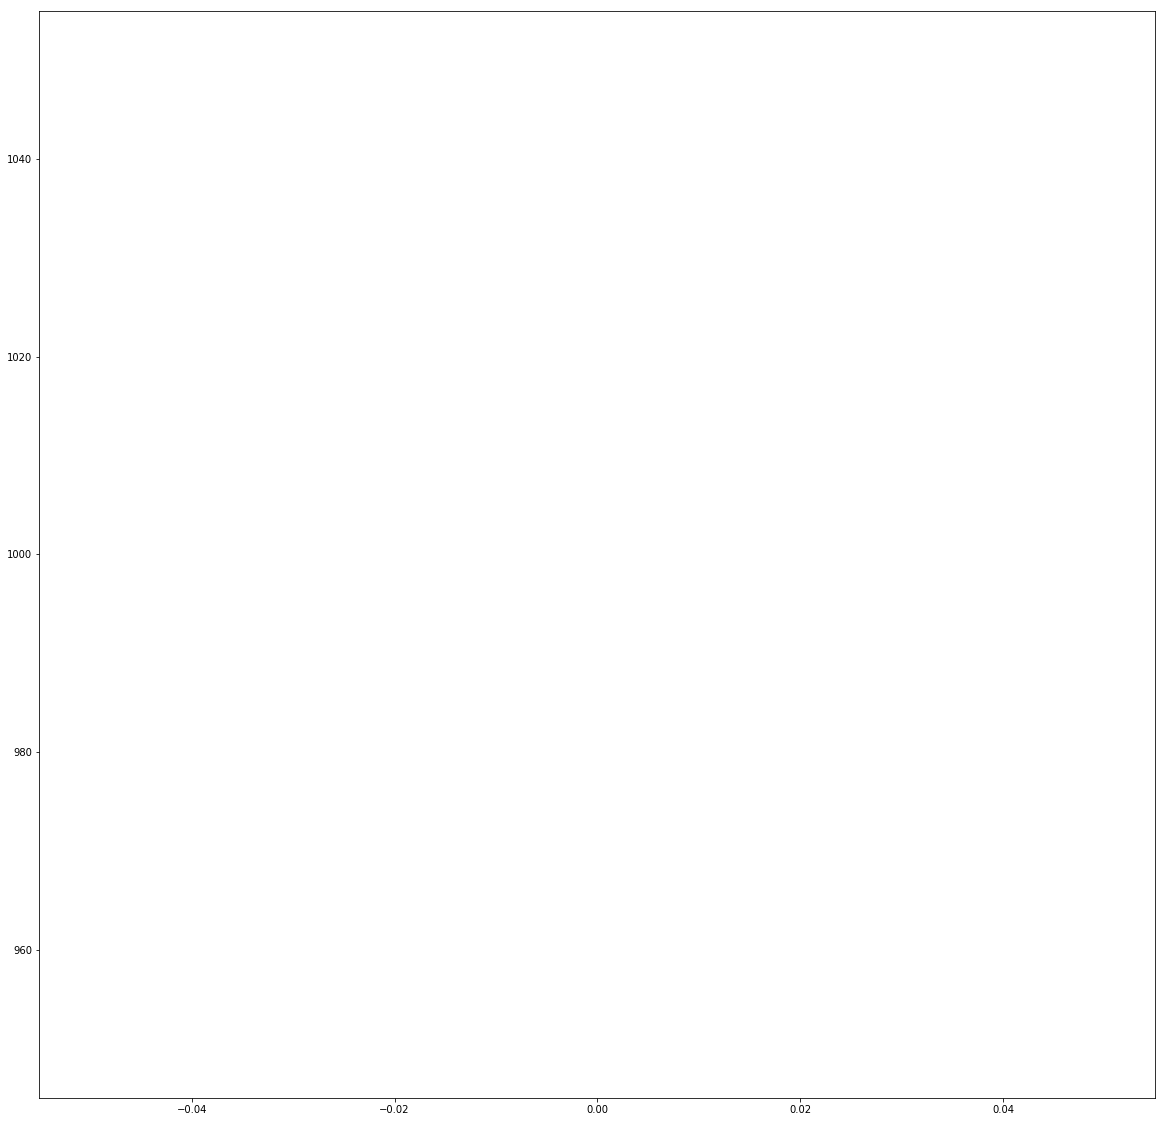

In [280]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20))
axs.scatter(xx, yy)
axs.plot([0, 0], [1000, 1000], 'k-')
plt.show()

In [306]:
model = MinMaxModel()
model.fit(train, train_answers)
tr_stat = model.predict(train).merge(train_answers, on=['itemId'])
tr_stat.head()

,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_true,Ymin_true,Xmax_true,Ymax_true
0,6132,39,637,276,831,47,650,213,812
1,31297,25,393,126,487,18,390,122,472
2,18168,159,718,587,1074,35,713,656,1082
3,8398,53,1019,61,1028,51,1021,59,1027
4,8774,116,959,795,1317,205,792,835,1309


In [307]:
scores = tr_stat.apply(lambda x: pd.Series([x.itemId,\
                         intersection_over_union([x.Xmin, x.Ymin, x.Xmax, x.Ymax, x.Xmin_true, x.Ymin_true, x.Xmax_true, x.Ymax_true])]\
                                 , index=['itemId', 'score']), 1)
tr_stat = tr_stat.merge(scores, on=['itemId'])

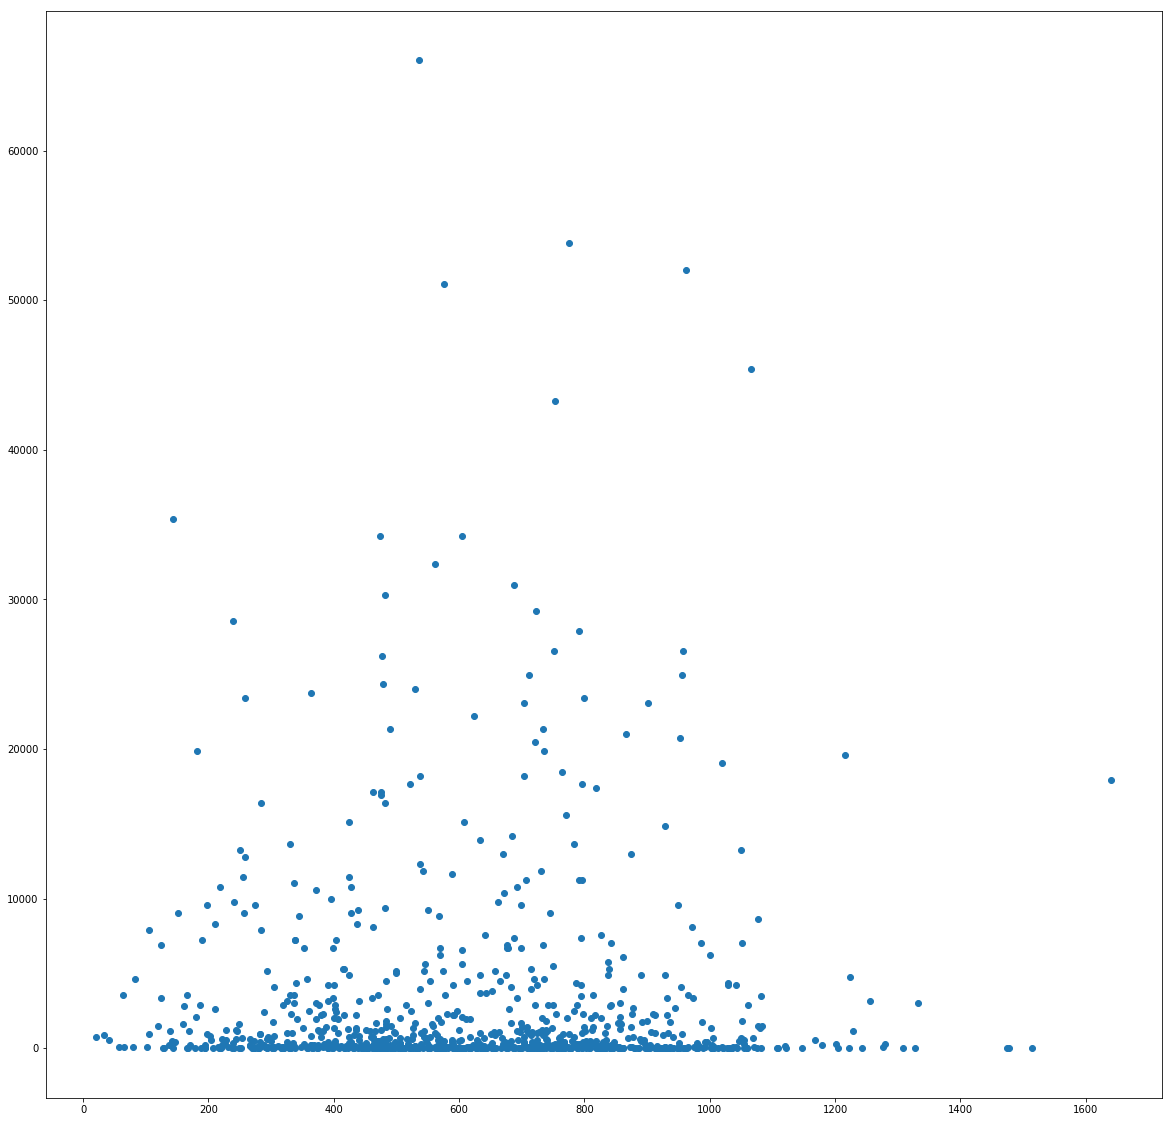

In [314]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20))
axs.scatter(tr_stat.Ymin_true, (tr_stat.Ymin_true - tr_stat.Ymin)**2)
plt.show()

In [161]:
for items in split_by(train, 'itemId'):
    items = list(items.itertuples())
    items = list(map(Rect, items))
    items.sort(key=lambda a: a.x1)
    a = all(items[i - 1].contains(items[i]) for i in range(1, len(items)))
    if (a):
        print(items[0].itemId)


118
2014
5797
8374
8520
11910
13855
16332
16809
16944
17177
18713
18756
23728
25135
26967
27956
29282
31033
31749
32631
35123


In [144]:
a = list(split_by(train, 'itemId')[0].itertuples())[0]

In [147]:
str(type(a))

"<class 'pandas.core.frame.Pandas'>"

In [146]:
pd.core.frame.Pandas

AttributeError: module 'pandas.core.frame' has no attribute 'Pandas'

In [110]:
ee = []
train.groupby('itemId').apply(lambda x: ee.append(x))
ee[0]

,userId,itemId,Xmin,Ymin,Xmax,Ymax
2988,141,5,210,925,483,1255
2989,903,5,151,917,511,1160
2990,1723,5,192,914,510,1331


In [105]:
type(train)

pandas.core.frame.DataFrame

In [112]:
x1_brd = []
x2_brd = []
y1_brd = []
y2_brd = []
for items in split_by(train.join(train_answers.set_index('itemId'), on='itemId'), 'itemId'):
    itemId = items.itemId.values[0]
    rect = Rect([items.Xmin_true.values[0], items.Ymin_true.values[0], items.Xmax_true.values[0], items.Ymax_true.values[0]])
    rect.itemId = items.itemId.values[0]
    rect.userId = items.userId.values[0]
    if items.Xmin.min() == items.Xmin_true.min():
        x1_brd.append(rect)
    if items.Ymin.min() == items.Ymin_true.min():
        y1_brd.append(rect)
    if items.Xmax.max() == items.Xmax_true.max():
        x2_brd.append(rect)
    if items.Ymax.max() == items.Ymax_true.max():
        y2_brd.append(rect)
        
print(len(x1_brd), len(x2_brd), len(y1_brd), len(y2_brd))

30 24 40 31


In [131]:
','.join(map(str, list(map(lambda x: x.itemId, x1_brd)) + list(map(lambda x: x.itemId, x2_brd)) + list(map(lambda x: x.itemId, y1_brd)) + list(map(lambda x: x.itemId, y2_brd))))

'1691,4322,5312,6013,7010,9523,9813,10004,10477,10544,12016,12488,13855,15374,18374,21223,21424,22483,25135,29550,30089,30683,31033,31749,32714,32928,33357,33551,34508,34791,4117,7555,10255,10477,10867,11258,12543,13983,14575,17216,18546,18729,20558,22483,23181,25135,26374,31033,32182,32551,34362,34990,34998,35648,1095,1147,3009,4257,4752,7761,9523,13007,13855,16045,16538,17177,17190,17449,17653,18093,21231,22330,22475,22483,23031,24763,25094,25135,25142,25324,26628,26973,28987,30615,30683,31033,31086,31515,32631,32954,33665,34114,34957,35476,843,1147,3973,4408,5014,9407,10255,11212,11258,12701,13194,13386,13855,14575,15096,22391,22483,23342,23416,23609,25014,25135,25142,25324,26489,28030,28597,29498,30215,31033,34114'

In [114]:
list(map(str, x1_brd))

['Rect[14, 353]*[302, 568]',
 'Rect[23, 58]*[359, 390]',
 'Rect[48, 87]*[819, 853]',
 'Rect[48, 67]*[924, 938]',
 'Rect[15, 244]*[439, 696]',
 'Rect[48, 80]*[854, 880]',
 'Rect[59, 259]*[980, 1134]',
 'Rect[34, 240]*[636, 783]',
 'Rect[40, 121]*[719, 774]',
 'Rect[27, 111]*[552, 594]',
 'Rect[34, 50]*[709, 719]',
 'Rect[21, 631]*[321, 772]',
 'Rect[56, 62]*[1121, 1127]',
 'Rect[41, 157]*[749, 883]',
 'Rect[35, 397]*[596, 783]',
 'Rect[32, 314]*[597, 784]',
 'Rect[40, 61]*[576, 584]',
 'Rect[37, 40]*[768, 770]',
 'Rect[45, 45]*[1243, 1243]',
 'Rect[16, 534]*[342, 663]',
 'Rect[28, 310]*[428, 519]',
 'Rect[45, 123]*[1222, 1300]',
 'Rect[47, 48]*[963, 963]',
 'Rect[56, 63]*[1013, 1019]',
 'Rect[40, 151]*[753, 830]',
 'Rect[31, 46]*[846, 861]',
 'Rect[48, 263]*[897, 1058]',
 'Rect[46, 183]*[960, 1062]',
 'Rect[30, 310]*[857, 1205]',
 'Rect[49, 280]*[890, 1012]']

In [122]:
(train_answers.Xmin_true <= 59).mean()

0.5418875927889714

In [123]:
(train.Xmin <= 59).mean()

0.3509462244706764

In [105]:
str(sorted(list(map(lambda a: a[1], x1_brd))))

'[14, 15, 16, 21, 23, 27, 28, 30, 31, 32, 34, 34, 35, 37, 40, 40, 40, 41, 45, 45, 46, 47, 48, 48, 48, 48, 49, 56, 56, 59]'

In [106]:
str(sorted(list(map(lambda a: a[1], x2_brd))))

'[36, 38, 39, 43, 45, 46, 47, 54, 55, 55, 56, 61, 75, 75, 93, 95, 95, 97, 181, 206, 209, 214, 239, 299]'

In [107]:
str(sorted(list(map(lambda a: a[1], y1_brd))))

'[16, 22, 22, 23, 25, 29, 31, 32, 33, 33, 33, 35, 37, 37, 38, 40, 40, 41, 43, 43, 45, 45, 46, 47, 48, 48, 51, 52, 53, 53, 54, 55, 56, 57, 58, 60, 82, 85, 101, 103]'

In [108]:
str(sorted(list(map(lambda a: a[1], y2_brd))))

'[31, 38, 44, 45, 48, 48, 57, 58, 60, 62, 74, 79, 83, 94, 95, 98, 100, 100, 102, 105, 133, 148, 176, 177, 179, 222, 243, 260, 323, 354, 528]'

In [98]:
train_answers.shape

(943, 5)

In [110]:
sorted(train_answers.Xmin_true.unique())

[-1,
 0,
 1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 111,
 112,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 127,
 128,
 129,
 130,
 131,
 132,
 135,
 136,
 138,
 139,
 140,
 141,
 142,
 143,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 153,
 155,
 156,
 157,
 158,
 159,
 160,
 162,
 163,
 164,
 165,
 167,
 169,
 172,
 173,
 174,
 175,
 176,
 178,
 181,
 186,
 187,
 189,
 193,
 195,
 197,
 198,
 199,
 201,
 202,
 204,
 205,
 207,
 209,
 210,
 211,
 212,
 214,
 215,
 216,
 218

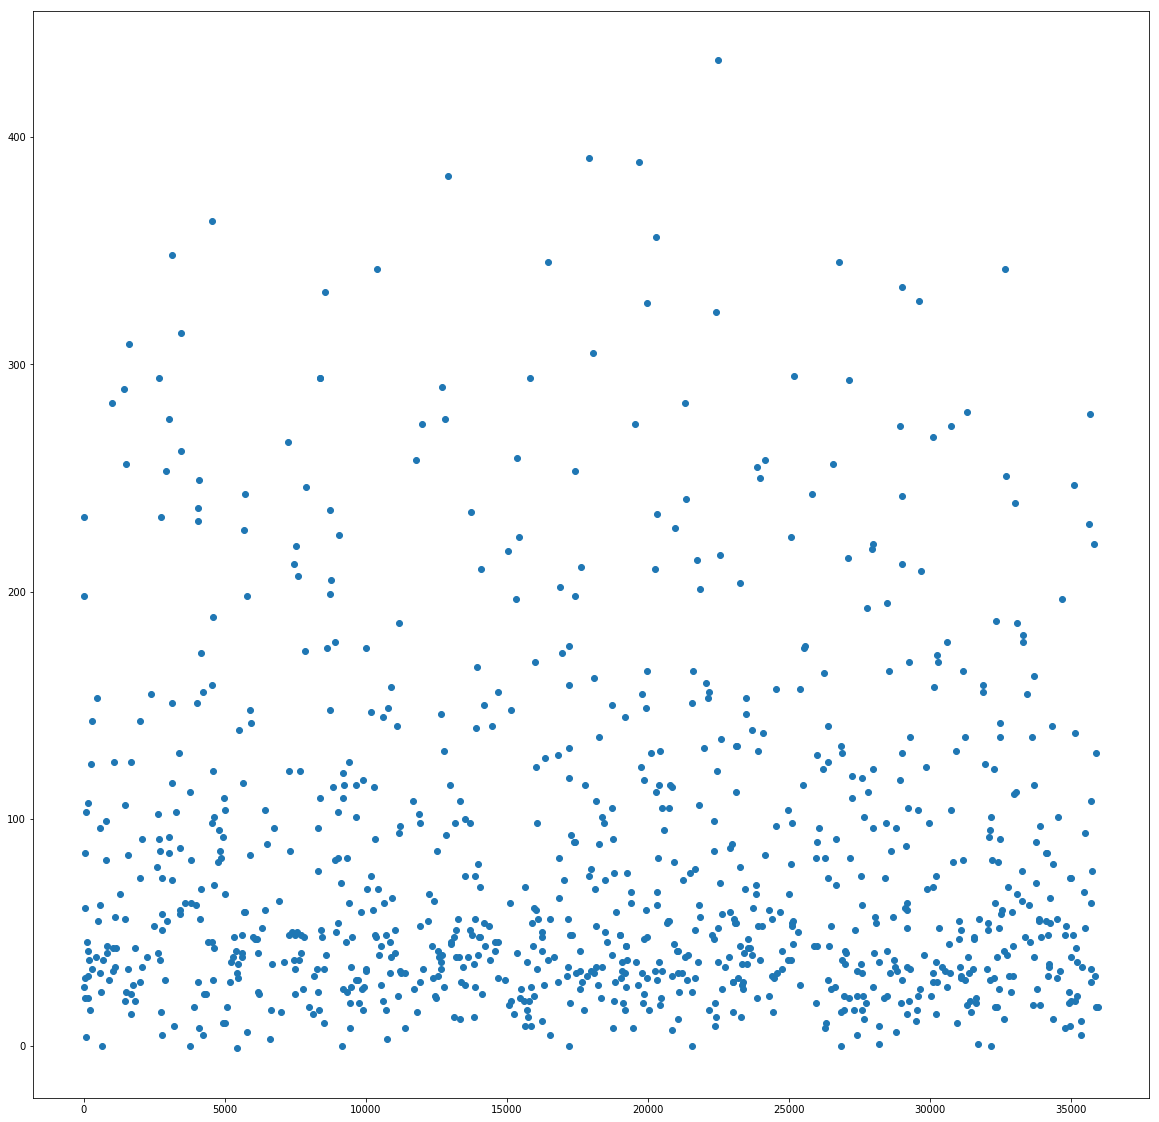

In [120]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20))
axs.scatter(train_answers.itemId, train_answers.Xmin_true)
plt.show()